<a href="https://colab.research.google.com/github/Jonaslbb/Stock-prediction-using-RNN/blob/main/Notebook/Stock%20Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Kilder:
# https://towardsdatascience.com/a-comprehensive-guide-to-downloading-stock-prices-in-python-2cd93ff821d4
# https://pypi.org/project/yfinance/

In [ ]:
!pip install yfinance

     |████████████████████████████████| 5.5MB 31.0MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22615 sha256=ad1a794d26c7bdffff970406c3f100e8ec5554a83b97dcefa4913286afefe43f
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
import pandas as pd
from pandas_datareader import data as web
from yfinance import Ticker
import datetime
import yfinance as yf

In [ ]:
stock = 'AMZN'
start_date = (datetime.datetime.now() - datetime.timedelta(days=1000)).strftime("%Y-%m-%d")
end_date = datetime.datetime.now().strftime("%Y-%m-%d")

In [ ]:
df = yf.download(stock, start=start_date, end=end_date, progress=False, interval='1d')

In [ ]:
df.columns = [w.lower() for w in df.columns]

In [ ]:
df['movement'] = df.close - df.open

In [ ]:
ticker = yf.Ticker(stock)

In [ ]:
recom = ticker.recommendations
recom

,Firm,To Grade,From Grade,Action
Date,,,,
2011-12-29 12:47:00,PiperJaffray,,,main
2012-02-15 07:33:00,PiperJaffray,Overweight,,main
2012-02-16 06:17:00,Morgan Stanley,Equal-Weight,,down
2012-04-02 06:06:00,Bank oferica,Neutral,,down
2012-04-27 06:21:00,Bank oferica,Buy,,up
...,...,...,...,...
2020-10-30 12:31:05,Credit Suisse,Outperform,,main
2020-10-30 16:53:12,Piper Sandler,Overweight,,main
2020-10-30 17:12:40,Benchmark,Buy,,main


Since we want to predict the closing stock price for the following day, we just shift the closing price one day to get our y value.

In [ ]:
df['close_y'] = df['close'].shift(-1, fill_value=df['close'].iloc[-1])

In [ ]:
df.head()

,open,high,low,close,adj close,volume,movement,close_y
Date,,,,,,,,
2018-03-19,1554.530029,1561.660034,1525.349976,1544.930054,1544.930054,6580800,-9.599976,1586.510010
2018-03-20,1550.339966,1587.000000,1545.410034,1586.510010,1586.510010,4581600,36.170044,1581.859985
2018-03-21,1586.449951,1590.000000,1563.170044,1581.859985,1581.859985,4750800,-4.589966,1544.920044
2018-03-22,1565.469971,1573.849976,1542.400024,1544.920044,1544.920044,6320600,-20.549927,1495.560059
2018-03-23,1539.010010,1549.020020,1495.359985,1495.560059,1495.560059,8006000,-43.449951,1555.859985


Since we are working with sequential data, we dont use train_test_split. Insted we pick the first 80% of obersavations as training set, and the remaning as testing set.

In [ ]:
test_size = int(len(df) * 0.2)
train = df.iloc[:-test_size,:].copy() 
test = df.iloc[-test_size:,:].copy()

We split the dataset into x values and y values. We also specify .values, since the date is not relevant for the training and dosn't work with some of the later preprocessing

In [ ]:
X_train = train.iloc[:,:-1].values
y_train = train.iloc[:,-1].values

X_test = test.iloc[:,:-1].values
y_test = test.iloc[:,-1].values

In [ ]:
from sklearn.preprocessing import MinMaxScaler

We scale all our values to be between -1 and 1. This should help the accuracy of the model.

In [ ]:
x_scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))

In [ ]:
X_train = x_scaler.fit_transform(X_train)
y_train = y_scaler.fit_transform(y_train.reshape(-1,1))


X_test = x_scaler.transform(X_test)
y_test = y_scaler.transform(y_test.reshape(-1,1))


In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator

Now we start making our RNN model. 

n_input = how many days we look in the past to predict the next sample. We chose 20 mostly by trial and error.

We set epochs to 100. It's our experience that the more you train the model, the more it will try to predict the daily volatility. If we only trained it for eg. 10 epochs, the model would make a soft curve which didn't look like a real stock development. By trail and error we found 100 to be the best training amount.

In [ ]:
n_input = 20
n_features= X_train.shape[1] # how many predictors/Xs/features we have to predict y
b_size = 30 # Number of timeseries samples in each batch
epochs = 100
generator = TimeseriesGenerator(X_train, y_train, length=n_input, batch_size=b_size)

In [ ]:
print(generator[0][0].shape)

(30, 20, 7)


In [ ]:
import numpy as np

In [ ]:
test_generator = TimeseriesGenerator(X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)
print(test_generator[0][0].shape)

(30, 20, 7)


In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

Since we are working with sequential stock data we chose an LSTM model, which is a RNN model.
Activation function is set to relu, and optimizer is adam, since these are the standard for this kind of task.
We chose 2 layers with 50 units each, and once again done by trial and error.

Since we want to predict the actual stock price we use mse(mean squared error) as our loss fuction.

In [ ]:
model = Sequential()
model.add(LSTM(50, activation='relu',return_sequences=True, input_shape=(n_input, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 50)            11600     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 31,851
Trainable params: 31,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(generator,epochs=epochs,verbose=1,validation_data=test_generator)

In [ ]:
import matplotlib.pyplot as plt

This looks like overfitting, but it works the best in our case.

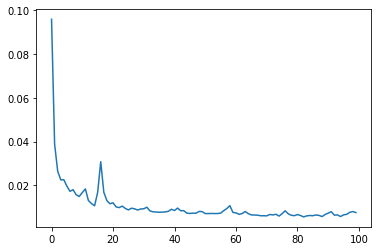

In [ ]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch);

In [ ]:
pd.DataFrame(X_test)

,0,1,2,3,4,5,6
0,0.854315,0.852881,0.880941,0.903690,0.903690,-0.639384,0.180448
1,0.909879,0.914080,0.960182,0.953379,0.953379,-0.721149,0.153326
2,0.942808,0.908059,0.962147,0.955753,0.955753,-0.775487,0.012279
3,0.944558,0.933683,0.989485,0.966135,0.966135,-0.756271,0.052121
4,0.960884,0.968285,0.970248,0.935285,0.935285,-0.718453,-0.165646
...,...,...,...,...,...,...,...
133,2.137747,2.160437,2.162522,2.143971,2.143971,-0.745336,-0.018841
134,2.141941,2.166404,2.125169,2.177404,2.177404,-0.672477,0.116125
135,2.157521,2.149227,2.069975,2.050729,2.050729,-0.561555,-0.540541
136,2.020780,2.091977,2.049290,2.046032,2.046032,-0.707354,0.069002


Then we do some data processing to get it back to the orginal format, so we can compare the real data to the predictions.

In [ ]:
y_pred_scaled = model.predict(test_generator)
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_test = y_scaler.inverse_transform(y_test)
results = pd.DataFrame({'y_true':y_test.flatten()[n_input:],'y_pred':y_pred.flatten()})
print(results)

          y_true       y_pred
0    2680.379883  2718.393555
1    2758.820068  2681.164062
2    2878.699951  2678.015381
3    2890.300049  2723.872070
4    3057.040039  2806.628418
..           ...          ...
113  3177.290039  3187.205078
114  3104.199951  3196.122559
115  3101.489990  3211.480957
116  3116.419922  3157.575439
117  3116.419922  3169.283936

[118 rows x 2 columns]


In [ ]:
model.evaluate(test_generator)

4/4 [==============================] - 0s 6ms/step - loss: 4.5979


4.59794282913208

Looks like the predictions follow the real data to some extent. It follows most of the ups and downs, but doesn't predict that well overall. Also, the model is not very consistant - sometimes it's pretty good and other times it's way off. This alone probably removes any kind of usefullnes for actually trading stocks based on this.

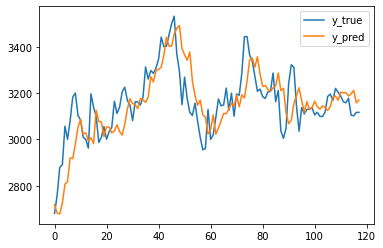

In [ ]:
results.plot()

In [ ]:
results["difference"] = results["y_true"]-results["y_pred"]

In [ ]:
results['change_true'] = results["y_true"] - results['y_true'].shift(+1, fill_value=train['close'].iloc[-1])
results['change_pred'] = results["y_pred"] - results['y_pred'].shift(+1, fill_value=train['close'].iloc[-1])
results["change_dif"] = results["change_true"]-results["change_pred"]

In [ ]:
results

,y_true,y_pred,difference,change_true,change_pred,change_dif
0,2680.379883,2718.393555,-38.013672,279.279785,317.293457,-38.013672
1,2758.820068,2681.164062,77.656006,78.440186,-37.229492,115.669678
2,2878.699951,2678.015381,200.684570,119.879883,-3.148682,123.028564
3,2890.300049,2723.872070,166.427979,11.600098,45.856689,-34.256592
4,3057.040039,2806.628418,250.411621,166.739990,82.756348,83.983643
...,...,...,...,...,...,...
113,3177.290039,3187.205078,-9.915039,19.290039,-14.430908,33.720947
114,3104.199951,3196.122559,-91.922607,-73.090088,8.917480,-82.007568
115,3101.489990,3211.480957,-109.990967,-2.709961,15.358398,-18.068359
116,3116.419922,3157.575439,-41.155518,14.929932,-53.905518,68.835449


this shows the actual daily change and the predicted daily change.
At this it actually does a pretty good job. The changes are not always in the right direction, but they are of a reasonable size.

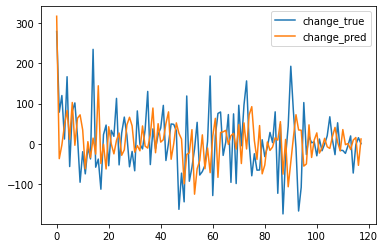

In [ ]:
results.iloc[:,3:5].plot()

Next we want to make a similar model, but we include trends from google trends. Our hypothesis is that stock prices follows the public interest in the company/product. So we download google trends data for the same period as the stock.

In [ ]:
!pip install pytrends

In [ ]:
from pytrends import dailydata

In [ ]:
amazon_data = dailydata.get_daily_data("amazon", start_year=2018, start_mon=1, stop_year=2020, stop_mon=12)

amazon:2018-01-01 2018-01-31
amazon:2018-02-01 2018-02-28
amazon:2018-03-01 2018-03-31
amazon:2018-04-01 2018-04-30
amazon:2018-05-01 2018-05-31
amazon:2018-06-01 2018-06-30
amazon:2018-07-01 2018-07-31
amazon:2018-08-01 2018-08-31
amazon:2018-09-01 2018-09-30
amazon:2018-10-01 2018-10-31
amazon:2018-11-01 2018-11-30
amazon:2018-12-01 2018-12-31
amazon:2019-01-01 2019-01-31
amazon:2019-02-01 2019-02-28
amazon:2019-03-01 2019-03-31
amazon:2019-04-01 2019-04-30
amazon:2019-05-01 2019-05-31
amazon:2019-06-01 2019-06-30
amazon:2019-07-01 2019-07-31
amazon:2019-08-01 2019-08-31
amazon:2019-09-01 2019-09-30
amazon:2019-10-01 2019-10-31
amazon:2019-11-01 2019-11-30
amazon:2019-12-01 2019-12-31
amazon:2020-01-01 2020-01-31
amazon:2020-02-01 2020-02-29
amazon:2020-03-01 2020-03-31
amazon:2020-04-01 2020-04-30
amazon:2020-05-01 2020-05-31
amazon:2020-06-01 2020-06-30
amazon:2020-07-01 2020-07-31
amazon:2020-08-01 2020-08-31
amazon:2020-09-01 2020-09-30
amazon:2020-10-01 2020-10-31
amazon:2020-11

In [ ]:
data = amazon_data.copy()

the data comes in different formats. We only want the collum called "amazon" which is normalized over the period.

In [ ]:
data=data.amazon 

Merging the trends on the stocks dataset and rearrange the columns, so we can reuse the code from the last model.

In [ ]:
df_merged = pd.merge(df,data,left_index=True,right_index=True)

In [ ]:
df_merged = df_merged[['open', 'high', 'low', 'close',"adj close","volume","movement","amazon","close_y"]]

In [ ]:
df_merged

,open,high,low,close,adj close,volume,movement,amazon,close_y
2018-03-19,1554.530029,1561.660034,1525.349976,1544.930054,1544.930054,6580800,-9.599976,53.69,1586.510010
2018-03-20,1550.339966,1587.000000,1545.410034,1586.510010,1586.510010,4581600,36.170044,54.87,1581.859985
2018-03-21,1586.449951,1590.000000,1563.170044,1581.859985,1581.859985,4750800,-4.589966,54.28,1544.920044
2018-03-22,1565.469971,1573.849976,1542.400024,1544.920044,1544.920044,6320600,-20.549927,51.33,1495.560059
2018-03-23,1539.010010,1549.020020,1495.359985,1495.560059,1495.560059,8006000,-43.449951,50.15,1555.859985
...,...,...,...,...,...,...,...,...,...
2020-12-03,3205.459961,3228.639893,3181.310059,3186.729980,3186.729980,2892000,-18.729980,90.21,3162.580078
2020-12-04,3198.209961,3198.209961,3158.760010,3162.580078,3162.580078,2913600,-35.629883,90.21,3158.000000
2020-12-07,3156.479980,3180.760010,3141.689941,3158.000000,3158.000000,2751300,1.520020,98.00,3177.290039
2020-12-08,3158.899902,3184.129883,3120.020020,3177.290039,3177.290039,3286300,18.390137,98.00,3104.199951


In [ ]:
train2 = df_merged.iloc[:-test_size,:].copy() 
test2 = df_merged.iloc[-test_size:,:].copy()

In [ ]:
X_train2 = train2.iloc[:,:-1].values
y_train2 = train2.iloc[:,-1].values

X_test2 = test2.iloc[:,:-1].values
y_test2 = test2.iloc[:,-1].values

In [ ]:
X_train2 = x_scaler.fit_transform(X_train2)
y_train2 = y_scaler.fit_transform(y_train2.reshape(-1,1))

X_test2 = x_scaler.transform(X_test2)
y_test2 = y_scaler.transform(y_test2.reshape(-1,1))

In [ ]:
generator2 = TimeseriesGenerator(X_train2, y_train2, length=n_input, batch_size=b_size)

In [ ]:
n_features2 = X_train2.shape[1] # how many predictors/Xs/features we have to predict y

The same model as before. Only difference it the addition of google trends.

In [ ]:
model2 = Sequential()
model2.add(LSTM(50, activation='relu',return_sequences=True, input_shape=(n_input, n_features2)))
model2.add(LSTM(50, activation='relu'))
model2.add(Dense(1))
model2.compile(optimizer='adam', loss='mse')
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 20, 50)            11800     
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 32,051
Trainable params: 32,051
Non-trainable params: 0
_________________________________________________________________


In [ ]:
test_generator2 = TimeseriesGenerator(X_test2, np.zeros(len(X_test2)), length=n_input, batch_size=b_size)
print(test_generator2[0][0].shape)

(30, 20, 8)


In [ ]:
model2.fit(generator2,epochs=epochs,verbose=1,validation_data=test_generator2)

In [ ]:
model2.evaluate(test_generator2)

4/4 [==============================] - 0s 6ms/step - loss: 8.7233


8.723335266113281

In [ ]:
y_pred_scaled2 = model2.predict(test_generator2)
y_pred2 = y_scaler.inverse_transform(y_pred_scaled2)
y_test2 = y_scaler.inverse_transform(y_test2)
results2 = pd.DataFrame({'y_true':y_test2.flatten()[n_input:],'y_pred':y_pred2.flatten()})
print(results2)

          y_true       y_pred
0    2754.580078  2657.918701
1    2692.870117  2668.937988
2    2680.379883  2696.924072
3    2758.820068  2685.837402
4    2878.699951  2696.384033
..           ...          ...
113  3162.580078  3786.461670
114  3158.000000  3886.912598
115  3177.290039  3930.269775
116  3104.199951  4015.585205
117  3101.489990  3963.584717

[118 rows x 2 columns]


The results are not any better tbh. Part of the problem might be that amazon trends during christmas every year, which might confuse the model more than it helps. Also amazon makes money of a lot of different things (eg. AWS), which probalby affects the stock price more than the trend.  

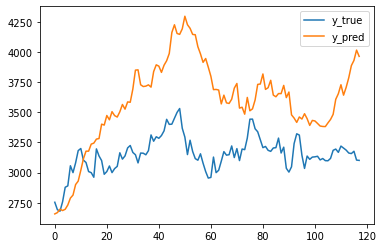

In [ ]:
results2.plot()

In [ ]:
results2['change_true'] = results2["y_true"] - results2['y_true'].shift(+1, fill_value=train['close'].iloc[-1])
results2['change_pred'] = results2["y_pred"] - results2['y_pred'].shift(+1, fill_value=train['close'].iloc[-1])
results2["change_dif"] = results2["change_true"]-results2["change_pred"]

In [ ]:
test2

,open,high,low,close,adj close,volume,movement,amazon,close_y
2020-05-27,2404.989990,2413.580078,2330.000000,2410.389893,2410.389893,5056900,5.399902,74.76,2401.100098
2020-05-28,2384.330078,2436.969971,2378.229980,2401.100098,2401.100098,3190200,16.770020,76.44,2442.370117
2020-05-29,2415.939941,2442.370117,2398.199951,2442.370117,2442.370117,3529300,26.430176,68.88,2471.040039
2020-06-01,2448.000000,2476.929932,2444.169922,2471.040039,2471.040039,2928900,23.040039,69.66,2472.409912
2020-06-02,2467.000000,2473.530029,2445.310059,2472.409912,2472.409912,2529900,5.409912,71.28,2478.399902
...,...,...,...,...,...,...,...,...,...
2020-12-03,3205.459961,3228.639893,3181.310059,3186.729980,3186.729980,2892000,-18.729980,90.21,3162.580078
2020-12-04,3198.209961,3198.209961,3158.760010,3162.580078,3162.580078,2913600,-35.629883,90.21,3158.000000
2020-12-07,3156.479980,3180.760010,3141.689941,3158.000000,3158.000000,2751300,1.520020,98.00,3177.290039
2020-12-08,3158.899902,3184.129883,3120.020020,3177.290039,3177.290039,3286300,18.390137,98.00,3104.199951


In [ ]:
results2

,y_true,y_pred,change_true,change_pred,change_dif
0,2754.580078,2657.918701,353.479980,256.818604,96.661377
1,2692.870117,2668.937988,-61.709961,11.019287,-72.729248
2,2680.379883,2696.924072,-12.490234,27.986084,-40.476318
3,2758.820068,2685.837402,78.440186,-11.086670,89.526855
4,2878.699951,2696.384033,119.879883,10.546631,109.333252
...,...,...,...,...,...
113,3162.580078,3786.461670,-24.149902,79.713379,-103.863281
114,3158.000000,3886.912598,-4.580078,100.450928,-105.031006
115,3177.290039,3930.269775,19.290039,43.357178,-24.067139
116,3104.199951,4015.585205,-73.090088,85.315430,-158.405518


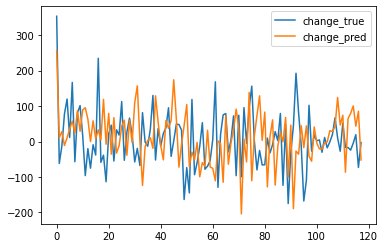

In [ ]:
results2.iloc[:,2:4].plot()

In [ ]:
test2['close'].iloc[n_input]

2734.39990234375